In [1]:
# Core Libraries
import pandas as pd
import numpy as np
from datetime import datetime
import math
import warnings
warnings.simplefilter(action='ignore')

# plotting 
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import networkx as nx

plt.style.use('seaborn-darkgrid')
%matplotlib inline

FIG_SIZE = (13,6)

In [98]:
IMG_FOLDER = 'filestore/analysis_output/img/'

# Analysing topic data

In [2]:
user_df = pd.read_csv("filestore/user/fact_user_dataset.csv").drop('Unnamed: 0',axis=1).drop('name', axis=1)
topics_df = pd.read_csv("filestore/user/dim_topics.csv").drop('Unnamed: 0',axis=1)

# There seems to be a user with joined = nan, filter them out
user_df = user_df[~user_df['joined'].isnull()]
topics_df['topic_id'] = topics_df['topic_id'].astype(object)

In [3]:
def convert_posix_time(t):
    return datetime.utcfromtimestamp(t / 1000)

In [4]:
user_df['joined'] = user_df['joined'].apply(convert_posix_time)
user_df['visited'] = user_df['visited'].apply(convert_posix_time)

In [5]:
user_df.head()

,bio,city,country,hometown,user_id,joined,lat,link,lon,state,status,topics,visited
0,Engineer working at Etsy,Dublin,ie,NaN,203627719,2017-04-18 22:36:19,53.33,http://www.meetup.com/members/203627719,-6.25,NaN,active,15236,2019-02-19 14:48:46
1,NaN,Anyang,kr,NaN,236920397,2018-01-10 10:55:54,37.39,http://www.meetup.com/members/236920397,126.92,NaN,active,"50881,563,26212,67622,48471,3833",2018-01-10 10:55:54
2,NaN,Dublin,ie,NaN,202430831,2019-03-23 10:51:08,53.33,http://www.meetup.com/members/202430831,-6.25,NaN,active,"59430,18551,65780,8476,48471,108403,682,9696,563",2019-04-08 07:36:11
3,NaN,Paris,fr,NaN,129312012,2016-02-12 22:08:19,48.86,http://www.meetup.com/members/129312012,2.34,NaN,active,"189,2260,16216,20346,21441,51642,9696,10306,10...",2016-02-14 21:20:05
4,NaN,Dublin,ie,NaN,242392259,2017-11-28 17:14:11,53.33,http://www.meetup.com/members/242392259,-6.25,NaN,active,"9696,15236,1924,8476,223,6144,39173,9349,206,1...",2018-06-19 10:58:20


In [6]:
user_df.dtypes

bio                 object
city                object
country             object
hometown            object
user_id              int64
joined      datetime64[ns]
lat                float64
link                object
lon                float64
state               object
status              object
topics              object
visited     datetime64[ns]
dtype: object

In [7]:
topics_df.head()

,urlkey,name,topic_id,target
0,business-networking,professional-networking,15236,pyladiesdublin
1,international-friends,International Friends,50881,pyladiesdublin
2,opensource,Open Source,563,pyladiesdublin
3,language-exchange,Language Exchange,26212,pyladiesdublin
4,culture-exchange,Culture Exchange,67622,pyladiesdublin


In [8]:
topics_df.dtypes

urlkey      object
name        object
topic_id    object
target      object
dtype: object

### Preparing the data

In [9]:
# There are some nulls in the data, remove them
user_df['topics'][user_df['topics'].isnull()] = '-'

In [10]:
user_topics = pd.DataFrame(
    user_df['topics']
    .str.split(',')
    .tolist(), index=user_df['user_id']) \
    .stack() \
    .reset_index([0, 'user_id'])
user_topics.columns = ['user_id', 'topic_id']
user_topics

,user_id,topic_id
0,203627719,15236
1,236920397,50881
2,236920397,563
3,236920397,26212
4,236920397,67622
...,...,...
12103,195659013,128595
12104,195659013,15582
12105,195659013,408
12106,236223844,48471


In [11]:
users_long = pd.merge(user_df, user_topics, on='user_id')
users_long.drop(['joined', 'lat','link', 'lon', 'state', 'status', 'visited', 'topics'], axis=1)

,bio,city,country,hometown,user_id,topic_id
0,Engineer working at Etsy,Dublin,ie,NaN,203627719,15236
1,NaN,Anyang,kr,NaN,236920397,50881
2,NaN,Anyang,kr,NaN,236920397,563
3,NaN,Anyang,kr,NaN,236920397,26212
4,NaN,Anyang,kr,NaN,236920397,67622
...,...,...,...,...,...,...
12103,NaN,Dublin,ie,Odense,195659013,128595
12104,NaN,Dublin,ie,Odense,195659013,15582
12105,NaN,Dublin,ie,Odense,195659013,408
12106,NaN,Dublin,ie,NaN,236223844,48471


In [12]:
# Remove duplicates, convert id to string for matching
unique_topics = topics_df.drop_duplicates()
unique_topics['topic_id'] = unique_topics['topic_id'].apply(lambda x: str(x))
unique_topics.columns = [c if c!='name' else 'topic_name' for c in unique_topics.columns]

In [13]:
unique_topics.columns

Index(['urlkey', 'topic_name', 'topic_id', 'target'], dtype='object')

In [14]:
user_topics = pd.merge(users_long, unique_topics, on='topic_id', how='left') \
    .loc[:, ['user_id', 'topic_name', 'topic_id']]

In [99]:
def top_n_barplot(df, col, start=0, end=15, rot=45, fname=None):
    data = df[col].value_counts(ascending=False)[start:end]
    fig, ax = plt.subplots(figsize=FIG_SIZE)
#     y = list(reversed(data.index))
    y = data.index.tolist()
    
    ax.barh(y=y, width=data)
    ax.set_ylim(ymin=-0.5, ymax=len(y))

    bar_list = ax.patches
    for bar, label in zip(bar_list, data):
        height = bar.get_height()
        ax.text( bar.get_width()*1.02,
                bar.get_y(), 
                label,
                ha='center', va='bottom')
        
    plt.style.use('seaborn-darkgrid')
    if fname:
        fig.savefig(IMG_FOLDER + fname)
    plt.show()

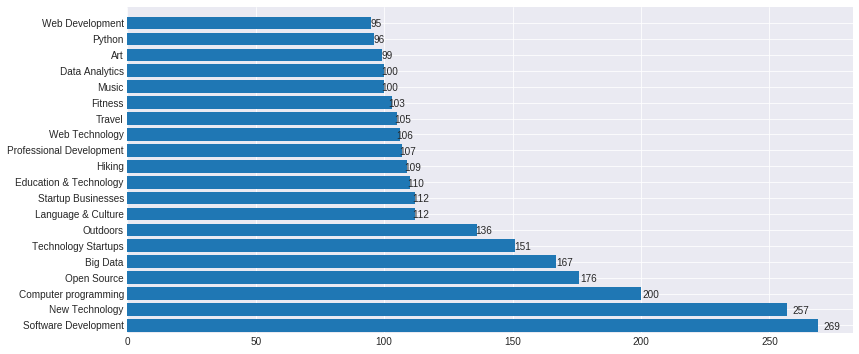

In [101]:
top_n_barplot(user_topics, 'topic_name', end = 20, rot=70, fname='top_topics.png')

In [83]:
len(user_topics['topic_name'].unique())

1482

In [42]:
one_user_mask = user_topics['topic_name'].value_counts() == 1
one_user_topics = user_topics['topic_name'].value_counts()[one_user_mask]
one_user_topics

Slovak Language           1
Twin Peaks                1
Treasure Hunts            1
Mandarin Pronunciation    1
JVM Languages             1
                         ..
Google                    1
Career                    1
Nannies                   1
Climbing and Abseiling    1
Active Mothers            1
Name: topic_name, Length: 746, dtype: int64

There are over 700 topics which have been selected only once, let's look at just a few of them 

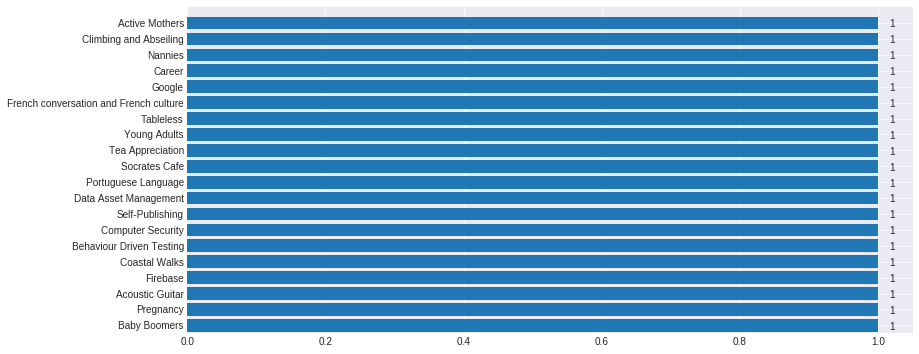

In [102]:
top_n_barplot(user_topics, 'topic_name', start=-20, end=None, rot=70, fname='bottom_topics.png')

## Convert the dataframe to graph

In [19]:
user_topics

,user_id,topic_name,topic_id
0,203627719,professional-networking,15236
1,236920397,International Friends,50881
2,236920397,Open Source,563
3,236920397,Language Exchange,26212
4,236920397,Culture Exchange,67622
...,...,...,...
12103,195659013,Internet Startups,128595
12104,195659013,Web Development,15582
12105,195659013,Vegan,408
12106,236223844,Computer programming,48471


In [20]:
def create_hash_key(df):
    f = lambda x: hash(x)
    df['h1'] = df['source'].apply(f)
    df['h2'] = df['target'].apply(f)
    df['hashed_key'] = df['h1'] ^ df['h2']
    return df.drop(['h1', 'h2'], axis=1)

Create a hash key which is a unique identifies for each pair (source, target).
That is, if there are two rows with values, (A,B) and (B,A), they are treated as the same

In [21]:
cartesian = pd.merge(user_topics, user_topics, on='user_id')
cartesian = cartesian[cartesian['topic_name_x'] != cartesian['topic_name_y']].reset_index()
cartesian = cartesian[['topic_name_x', 'topic_name_y']] 
cartesian.columns = ['source', 'target']
cartesian = create_hash_key(cartesian)

In [22]:
len(cartesian)

368351

Count the number of times each pair of topics appear.

In [23]:
hash_edge_count = cartesian.groupby('hashed_key', as_index=False)['source'].count()
hash_edge_count['source'] = hash_edge_count['source']-1
hash_edge_count.rename({'source':'weight'}, axis=1, inplace=True)

Create ref table for each topic pair and its hash

In [24]:
topic_hash_map = cartesian.groupby('hashed_key', as_index=False)['source', 'target'].first()

In [86]:
topic_edges = pd.merge(topic_hash_map, hash_edge_count, on='hashed_key').drop(['hashed_key'], axis=1)
topic_edges.sort_values(['weight', 'source'], ascending=False).head(10)

,source,target,weight
64617,New Technology,Software Development,325
19708,Computer programming,Software Development,281
47657,Open Source,Software Development,265
658,Technology Startups,Software Development,229
37916,Computer programming,New Technology,223
24035,Technology Startups,New Technology,221
69571,Big Data,Software Development,217
70667,New Technology,Open Source,211
46776,New Technology,Big Data,207
15053,Open Source,Computer programming,205


In [26]:
len(topic_edges)

82585

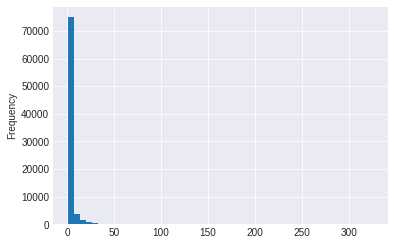

In [103]:
topic_edges[weight_hist]['weight'].plot(kind='hist', bins=50)

Data is in the right shape, but there are too many edges with weight 1

In [27]:
topic_edges['weight'].value_counts()

1      56608
3      10932
5       4757
7       2650
9       1691
       ...  
121        1
105        1
163        1
207        1
117        1
Name: weight, Length: 81, dtype: int64

In [28]:
topic_edges[topic_edges['weight']>80]['weight'].value_counts()

81     11
89      8
101     7
87      7
91      6
83      6
93      5
97      5
95      5
85      4
113     4
111     3
103     3
99      3
135     2
139     2
127     2
129     2
107     2
115     2
155     1
131     1
133     1
121     1
265     1
117     1
153     1
141     1
281     1
221     1
163     1
229     1
223     1
325     1
205     1
207     1
105     1
123     1
211     1
217     1
Name: weight, dtype: int64

Lets start with a graph for edges with weight > 80

In [29]:
G_80_weight = nx.from_pandas_edgelist(
    topic_edges[topic_edges['weight']>80],
    edge_attr=True)

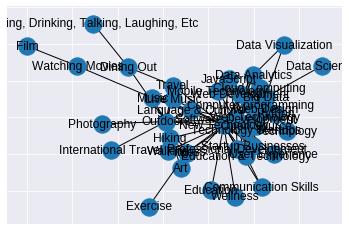

In [30]:
nx.draw_networkx(G_80_weight)

In [31]:
G = nx.from_pandas_edgelist(
    topic_edges,
    edge_attr=True)

## Creating some centrality metrics

In [32]:
graph_measures = {
    'degree_centrality' : nx.degree_centrality,
    'betweenness_centrality' : nx.betweenness_centrality,
    'eigenvector_centrality' : nx.eigenvector_centrality,
    'pagerank_centrality' : nx.pagerank
}

def get_measure(df, measure):
    G = nx.from_pandas_edgelist(df)
    measure_df = (
        pd.DataFrame({
            k:[v] 
            for k,v 
            in graph_measures[measure](G).items()
        })
        .T
        .reset_index()
        .rename({'index':'source', 0: measure},axis=1))
    return pd.merge(df, measure_df, on='source').drop_duplicates()

Since the full network is very large, let's start by considering only edges with weight> 80 

In [33]:
edges_gt80_df = topic_edges[topic_edges['weight']>80]
for k,v in graph_measures.items():
    edges_gt80_df = get_measure(edges_gt80_df, k)

G_80_weight = nx.from_pandas_edgelist(
    edges_gt80_df,
    edge_attr=True)
nx.write_graphml(G_80_weight, './networks/topic_network_80_weight.graphml')

Doing the same for the full network

In [34]:
output_measures = False

if output_measures:
    graph_df = topic_edges
    for k,v in graph_measures.items():
        graph_df = get_measure(graph_df, k)

    G = nx.from_pandas_edgelist(
        graph_df,
        edge_attr=True) 
    nx.write_graphml(G, './networks/topic_network.graphml')
else:
    G = nx.from_pandas_edgelist(
        topic_edges,
        edge_attr=True) 
    nx.write_graphml(G, './networks/topic_network.graphml')

## Some things to examine:
* Maximal connected subgraph will give a list of all topics that in some way link to the central node
* Conversely, it could be interesting analysing topics that aren't connected to the maximal subgraph
* other ?

In [35]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1481
Number of edges: 82585
Average degree: 111.5260


In [36]:
list(nx.connected_components(G))

[{'Diet',
  'Computer programming',
  'Drinking',
  'Wilderness Hiking',
  'Off-Leash Dog Recreation',
  'Russian Culture',
  'Edinburgh',
  'Best way to prepare a PCB board.',
  'Positive Thinking',
  'Ethnic Dining & Cooking',
  'Customer Data Platform',
  'Asian Professionals',
  'Basketball',
  'Sport Climbing',
  'Women Who Travel',
  'Data Journalism',
  'Motivation',
  'Boating',
  'Bamboo',
  'Energy Healing',
  'Exploring',
  "Women's Networking",
  'Machine Learning with Python',
  'Mental and Physical Health',
  'Community Organizations',
  'Wine Tasting',
  'Sacred Feminine',
  'Visual Studio',
  'Sustainable Development',
  'Software Testing',
  'computer-programming',
  'Performing Arts',
  'Spoken Word',
  'Manga',
  'Architecture',
  "What's Popular in China",
  'Business Strategy',
  'Studio Photography',
  'Music',
  'Docker Kubernetes',
  'Parents',
  'Black Singles',
  'Astronomy',
  'Star Trek',
  'Stackless Python',
  'Data Driven Design',
  'Data Computing',
  'S

In [37]:
cluster_G = nx.clustering(G, weight='weight')

In [38]:
max(cluster_G, key=cluster_G.get)

'Elm Programming'

In [39]:
max_cluster_coeff = cluster_G['Elm Programming']
max_cluster_coeff

0.013330125330730677